# Fried et al. (2011) Population Decoding Analysis

Goals:
1. Recreate figure 5 from Fried, Mukamel, & Kreiman, 2011, where they use a classifier to distinguish activity from a baseline.
2. Apply the same analysis to simulated data (fast and slow synapse networks) and see if we find something similar
3. Train and test decoders on different timepoints to see the generalizability of decoding accuracy


In [1]:
import numpy as np

from scipy.optimize import minimize
from scipy.io import loadmat,savemat
from scipy.linalg import fractional_matrix_power
from scipy import interpolate, signal,stats
from scipy.stats import ranksums, sem, ttest_ind
from scipy.ndimage.filters import uniform_filter1d
from scipy.ndimage import gaussian_filter1d

from os import listdir

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Ridge
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

import random

import pandas as pd


import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

from plotnine import *


import seaborn as sns

In [2]:
# Useful functions
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]



## Real Data

The code below will extract a matrix of Neurons X Trials X Time in the variable agdata by taking 40 trials from subjects/sessions with at least 40 trials and then concatenating them together

In [3]:
fpath = './data_real/'
files = find_csv_filenames(fpath,suffix=".mat")

data = {}

for file in files:
    temp = loadmat(fpath+file)
    
    if temp['region'] not in ['LAC','LACCr','LACr' ,'LDAC' ,'LRAC' ,'LSMA' ,'LpSMA','RAC'  ,'RACCr','RACr' ,'RRAC' ,'RSMA' ,'RpSMA']:
        continue
    
    key = '_'.join([str(temp['subj'][0][0]),str(temp['session'][0][0]),str(temp['ntrials'][0][0])])
    
    if key not in data.keys():
#         data[key] = [np.empty(temp['FRs'].shape)]
        data[key] = []

#     psth = temp['WAlignedSpikes']
    psth = temp['StopAlignedSpikes']

    
    data[key].append(psth)
    
for key in sorted(data.keys()):
#     print(len([_ for _ in data[key]]),'\n')
    data[key] = np.stack(data[key])

FileNotFoundError: [WinError 3] The system cannot find the path specified: './data_real/'

In [4]:
# temp

In [13]:
frames = []
not_good = 0
for key in data.keys():
    print(key,data[key].shape)
    # If 
    if (data[key].shape[0] >= 3) & (data[key].shape[1] > 40):
#     if (data[key].shape[0] == 37):

        
        frames.append(data[key][:,:40,:])
    else:
        not_good += 1
        
print(f"\n\nBad cases: {not_good} out of {len(data.keys())}")        
spks = np.concatenate(frames,axis=0)
time = np.linspace(-3.5,0,spks.shape[2])

4_4_34 (35, 34, 3501)
4_2_46 (31, 46, 3501)
1_1_63 (30, 63, 3501)
6_1_20 (27, 20, 3501)
4_1_33 (29, 33, 3501)
10_1_54 (28, 54, 3501)
5_2_43 (15, 43, 3501)
7_1_11 (9, 11, 3501)
3_1_15 (17, 15, 3501)
8_2_65 (27, 65, 3501)
4_5_40 (38, 40, 3501)
6_2_42 (29, 42, 3501)
4_3_51 (26, 51, 3501)
5_4_61 (14, 61, 3501)
6_3_17 (18, 17, 3501)
5_3_69 (9, 69, 3501)
8_1_65 (18, 65, 3501)
6_4_21 (31, 21, 3501)
4_6_50 (33, 50, 3501)
5_1_59 (16, 59, 3501)
11_1_48 (27, 48, 3501)
10_2_49 (16, 49, 3501)
7_2_16 (8, 16, 3501)
12_2_93 (4, 93, 3501)


Bad cases: 9 out of 24


In [19]:
baseline_ix = np.where(np.logical_and(time > -3,time < -2.6))[0]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

df_base = pd.DataFrame(baseline_frs.T)
df_base['label'] = np.zeros(len(df_base,))

accs = []
sems = []

for tt in time[time > -2.5][::50]:
    
    this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[0]
    this_frs = spks[:,:,this_ix].sum(axis=2)
    
    df_this = pd.DataFrame(this_frs.T)
    df_this['label'] = np.ones(len(df_this,))
    
    tmp = pd.concat([df_base,df_this]).dropna()
    
    X = tmp.drop('label',axis=1).to_numpy()
    y = tmp['label'].to_numpy().flatten()
    
    
    kf = KFold(n_splits=5, random_state=0,shuffle=True)
    
    accs_this = []

    for train_ix, test_ix in kf.split(X):
        
#         clf = LDA()
        clf = SVC()
        
        clf.fit(X[train_ix],y[train_ix])
        
        accs_this.append(clf.score(X[test_ix],y[test_ix]))
#         accs_this.append(roc_auc_score(y[test_ix],clf.predict_proba(X[test_ix])[:,1]))
        
    accs.append(np.mean(accs_this))
    sems.append(sem(accs_this))
    
    print(tt,np.mean(accs_this))
        
        
accs = np.array(accs)
sems = np.array(sems)
        
time_decim = time[time > -2.5][::50]
print(f"Real decoding AUC reaches 75% at {time_decim[np.where(accs > 0.75)[0][0]]}")

-2.4989999999999997 0.2625
-2.449 0.2625
-2.399 0.275
-2.349 0.2875
-2.299 0.3
-2.2489999999999997 0.325
-2.199 0.375
-2.149 0.35
-2.099 0.35
-2.049 0.35
-1.9989999999999999 0.3375
-1.949 0.3625
-1.899 0.3875
-1.849 0.3875
-1.799 0.3875
-1.7489999999999999 0.4125
-1.699 0.4
-1.649 0.4125
-1.599 0.4375
-1.549 0.45
-1.499 0.5
-1.4489999999999998 0.6
-1.399 0.6
-1.3489999999999998 0.6
-1.299 0.7125
-1.249 0.75
-1.1989999999999998 0.7625
-1.149 0.775
-1.0989999999999998 0.85
-1.049 0.8375
-0.9990000000000001 0.875
-0.9489999999999998 0.875
-0.899 0.875
-0.8489999999999998 0.9
-0.7989999999999999 0.8875
-0.7490000000000001 0.925
-0.6989999999999998 0.95
-0.649 0.95
-0.5989999999999998 0.9625
-0.5489999999999999 0.95
-0.4990000000000001 0.95
-0.44899999999999984 0.95
-0.399 0.975
-0.34899999999999975 0.9875
-0.29899999999999993 0.975
-0.2490000000000001 0.9875
-0.19899999999999984 1.0
-0.14900000000000002 1.0
-0.09899999999999975 0.9875
-0.04899999999999993 0.9875
Real decoding AUC reaches 7

In [20]:
accs_shuffle = []
sems_shuffle = []

for tt in time[time > -2.5][::50]:
    
    this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[0]
    this_frs = spks[:,:,this_ix].sum(axis=2)
    
    df_this = pd.DataFrame(this_frs.T)
    df_this['label'] = np.ones(len(df_this,))
    
    tmp = pd.concat([df_base,df_this]).dropna()
    
    X = tmp.drop('label',axis=1).to_numpy()
    accs_this = []


    
    for ii in range(100):
        
        try:
            y = tmp['label'].to_numpy().flatten()
            random.shuffle(y)


            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=ii)


#             clf = LDA()
            clf = SVC()

            clf.fit(X_train,y_train)

            accs_this.append(clf.score(X_test,y_test))
#             accs_this.append(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))
        except:
            print(f"Random state {ii} does not work for calculating AUC")


        
    accs_shuffle.append(np.mean(accs_this))
        
        

        
accs_shuffle = np.array(accs_shuffle)
        
    

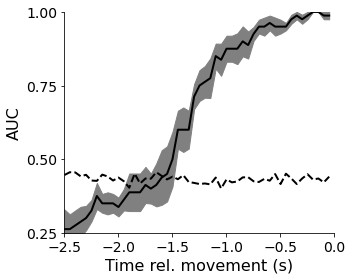

In [21]:
fig = plt.figure(figsize=(5,4))

ax = plt.gca()

plt.plot(time[time > -2.5][::50],accs,'k',lw=2)
plt.fill_between(time[time > -2.5][::50],accs+sems,accs-sems,color='gray')


plt.plot(time[time > -2.5][::50],accs_shuffle,'k--',lw=2)
# plt.fill_between(time[time > -2.5][::25],accs+sems,accs-sems,color='gray')


plt.xlim((-2.5,0))
plt.ylim((0.3,1))

plt.xlabel('Time rel. movement (s)',fontsize=16)
plt.ylabel('AUC',fontsize=16)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(-2.5,0.1,0.5))
ax.set_yticks(np.arange(0.25,1.1,0.25))
ax.tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('figures/decoding/svc_real_clf_mfc.svg')
plt.savefig('figures/decoding/svc_real_clf_mfc.png')


plt.show()

# Euclidean Distance

In [168]:
def vec_dist(a,b):
    return ((a-b) @ (a-b))**(1/2)

In [169]:
frames = []

baseline_ix = np.where(np.logical_and(time > -3.,time < -2.6))[0]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)



for tt in time[time > -3][::50]:
    distances = []
    
    this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[0]
    this_frs = spks[:,:,this_ix].sum(axis=2)
    
    for trialnum in range(spks.shape[1]):
        distances.append(vec_dist(baseline_frs[:,trialnum],this_frs[:,trialnum]))
    
    df_t = pd.DataFrame({
        'distance':distances
    })
    
    df_t['time'] = tt
    
    frames.append(df_t)
    
df_dist = pd.concat(frames)
        
        

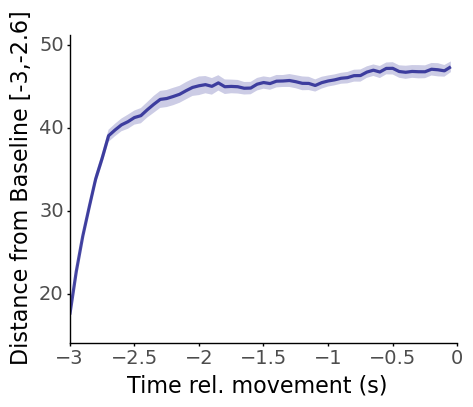

<ggplot: (435206696)>

In [171]:
df_temp = df_dist.groupby(['time'],as_index=False).mean()

df_temp['stderr'] = df_dist.groupby(['time'],as_index=False).sem()['distance']

df_temp['ci_high'] = df_temp.distance + df_temp.stderr
df_temp['ci_low'] = df_temp.distance - df_temp.stderr

p=(ggplot(df_temp,aes(x='time',y='distance', ymin = 'ci_low',ymax = 'ci_high')) +
geom_line(alpha=0.7,size=1.3,color='navy') + 
   geom_ribbon(alpha=0.2,color='none',show_legend=False,fill='navy') +
   scale_x_continuous(name='Time rel. movement (s)',breaks=np.arange(-3,1,0.5),limits=(-2.5,0.),expand = (0,0)) +
   scale_y_continuous(name='Distance from Baseline [-3,-2.6]',expand = (0.1,0.1)) +
   
 theme_classic() +
   theme(axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
        figure_size = (5,4))
)


# p.save(figurepath+'pupil/means_CI.svg')
# p.save(figurepath+'pupil/means_CI.png')
p

In [207]:
spks.shape

spks_temp = spks[np.where(np.sum(spks,(1,2)) > 10)[0],:,:]
spks_temp.shape

(321, 30, 3501)

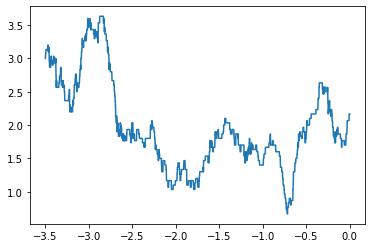

In [218]:
spks_mean = uniform_filter1d(spks_temp*1000,400)

spks_mean = np.mean(spks_mean,axis=1)

plt.plot(time,spks_mean2[1,:])

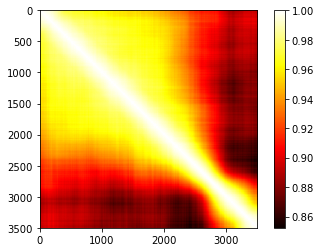

In [219]:
spks_cov = np.corrcoef(spks_mean.T)
plt.imshow(spks_cov, cmap='hot', interpolation='nearest')

plt.colorbar()

plt.show()

## Temporal generalization analysis

In [22]:
baseline_ix = np.where(np.logical_and(time > -3,time < -2.6))[0]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

df_base = pd.DataFrame(baseline_frs.T)
df_base['label'] = np.zeros(len(df_base,))

accs = []
# sems = []
traintime = []
testtime = []

for tt_train in time[time > -2.5][::50]:
    for tt_test in time[time > -2.5][::50]:
        
    

        train_ix = np.where(np.logical_and(time > tt_train-0.4,time < tt_train))[0]
        train_frs = spks[:,:,train_ix].sum(axis=2)

        df_train = pd.DataFrame(train_frs.T)
        df_train['label'] = np.ones(len(df_train,))

        tmp = pd.concat([df_base,df_train]).dropna()
        X_train = tmp.drop('label',axis=1).to_numpy()
        y_train = tmp['label'].to_numpy().flatten()

        test_ix = np.where(np.logical_and(time > tt_test - 0.4,time < tt_test))[0]
        test_frs = spks[:,:,test_ix].sum(axis=2)

        df_test = pd.DataFrame(test_frs.T)
        df_test['label'] = np.ones(len(df_test,))

        tmp = pd.concat([df_base,df_test]).dropna()
        X_test = tmp.drop('label',axis=1).to_numpy()
        y_test = tmp['label'].to_numpy().flatten()

#         clf = LDA()
        clf = SVC()

        clf.fit(X_train,y_train)

        accs_this = clf.score(X_test,y_test)
#         accs_this = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

        accs.append(accs_this)
        traintime.append(tt_train)
        testtime.append(tt_test)
        
        if tt_train == tt_test:
            print(tt_train,np.mean(accs_this))
        
        
df_tempgen = pd.DataFrame({'accs':accs,'traintime':traintime,'testtime':testtime})

print("T-Test output: ",ttest_ind(df_tempgen.loc[df_tempgen.traintime.values > df_tempgen.testtime.values,'accs'],
               df_tempgen.loc[df_tempgen.traintime.values < df_tempgen.testtime.values,'accs']))
print("Rank-Sum output: ",ranksums(df_tempgen.loc[df_tempgen.traintime.values > df_tempgen.testtime.values,'accs'],
               df_tempgen.loc[df_tempgen.traintime.values < df_tempgen.testtime.values,'accs']))

-2.4989999999999997 0.9375
-2.449 0.925
-2.399 0.9625
-2.349 0.95
-2.299 0.95
-2.2489999999999997 0.9625
-2.199 0.9875
-2.149 0.975
-2.099 0.9625
-2.049 0.9625
-1.9989999999999999 0.9625
-1.949 0.9625
-1.899 0.975
-1.849 0.975
-1.799 0.975
-1.7489999999999999 0.975
-1.699 0.9875
-1.649 0.9875
-1.599 0.9875
-1.549 1.0
-1.499 1.0
-1.4489999999999998 1.0
-1.399 1.0
-1.3489999999999998 1.0
-1.299 0.9875
-1.249 1.0
-1.1989999999999998 0.9875
-1.149 0.9875
-1.0989999999999998 0.975
-1.049 0.9875
-0.9990000000000001 1.0
-0.9489999999999998 1.0
-0.899 1.0
-0.8489999999999998 1.0
-0.7989999999999999 1.0
-0.7490000000000001 1.0
-0.6989999999999998 1.0
-0.649 1.0
-0.5989999999999998 1.0
-0.5489999999999999 1.0
-0.4990000000000001 1.0
-0.44899999999999984 1.0
-0.399 1.0
-0.34899999999999975 1.0
-0.29899999999999993 1.0
-0.2490000000000001 1.0
-0.19899999999999984 1.0
-0.14900000000000002 1.0
-0.09899999999999975 1.0
-0.04899999999999993 1.0
T-Test output:  Ttest_indResult(statistic=-24.14051709409

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/svc_real_2D_mfc.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/svc_real_2D_mfc.png


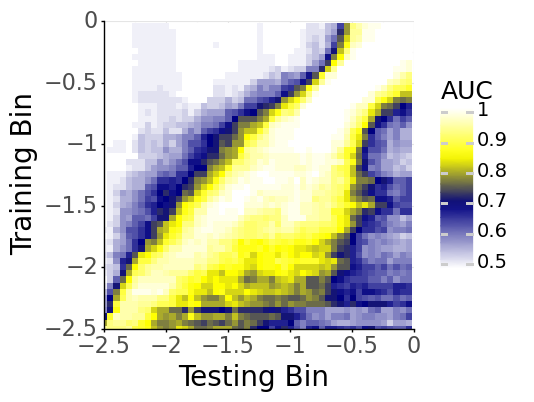

<ggplot: (437735108)>

In [23]:
p = (ggplot(df_tempgen,aes(x='testtime',y='traintime',fill='accs')) +
     geom_raster(interpolate=False)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
#      scale_fill_gradient2(name='AUC',
#                           high = 'yellow', # More vibrant
#                           low = 'white',
#                           mid = 'navy',
#                           na_value='white',
#                           midpoint=0.7,
#                           limits=(0.5,0.8)) +
     scale_fill_gradientn(name='AUC',
                          colors = ['white','navy','yellow','white'],
                          values = [0.,0.4,0.7,1],
                          na_value='white',
                          limits=(0.5,1)) +
     scale_x_continuous(name='Testing Bin') +
     scale_y_continuous(name='Training Bin') +
     coord_cartesian(xlim = (-2.5,0), ylim = (-2.5,0),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save('figures/svc_real_2D_mfc.svg')
p.save('figures/svc_real_2D_mfc.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

In [17]:
df_tempgen[df_tempgen.traintime.values==df_tempgen.testtime.values].accs.unique()

array([0.69444444, 0.69777778, 0.65111111, 0.67      , 0.70888889,
       0.72888889, 0.73444444, 0.70666667, 0.72444444, 0.75777778,
       0.76222222, 0.72777778, 0.77666667, 0.77777778, 0.77      ,
       0.78666667, 0.77444444, 0.73666667, 0.76111111, 0.78      ,
       0.78777778, 0.78222222, 0.81      , 0.86444444, 0.85888889,
       0.86444444, 0.87333333, 0.86111111, 0.84555556, 0.84      ,
       0.82333333, 0.79555556, 0.82888889, 0.84222222, 0.88111111,
       0.87666667, 0.86888889, 0.88666667, 0.89111111, 0.91888889,
       0.90555556, 0.9       , 0.91      , 0.89888889, 0.87222222,
       0.91777778, 0.92777778])

In [18]:
df_temp = df_tempgen.groupby(['testtime'],as_index=False).mean()
df_temp.head()

,testtime,accs,traintime
0,-2.499,0.534822,-1.274
1,-2.449,0.541467,-1.274
2,-2.399,0.555956,-1.274
3,-2.349,0.582511,-1.274
4,-2.299,0.603578,-1.274


In [19]:
df_temp

,testtime,accs,traintime
0,-2.499,0.534822,-1.274
1,-2.449,0.541467,-1.274
2,-2.399,0.555956,-1.274
3,-2.349,0.582511,-1.274
4,-2.299,0.603578,-1.274
5,-2.249,0.617556,-1.274
6,-2.199,0.636844,-1.274
7,-2.149,0.651511,-1.274
8,-2.099,0.653000,-1.274
9,-2.049,0.670000,-1.274


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/real_tempgen_avg_mfc.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/real_tempgen_avg_mfc.png


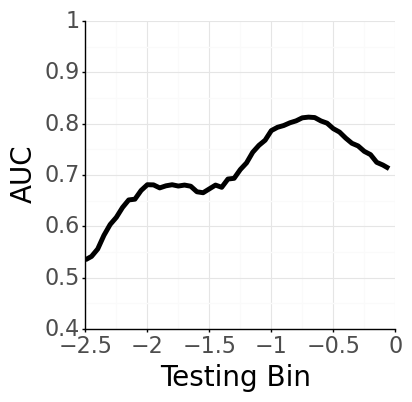

<ggplot: (434460067)>

In [20]:
df_temp = df_tempgen.groupby(['testtime'],as_index=False).mean()

p = (ggplot(df_temp,aes(x='testtime',y='accs')) +
     geom_line(color='black',size=2)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_x_continuous(name='Testing Bin') +
     scale_y_continuous(name='AUC') +
     coord_cartesian(xlim = (-2.5,0), ylim = (0.4,1),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save('figures/real_tempgen_avg_mfc.svg')
p.save('figures/real_tempgen_avg_mfc.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

In [72]:
df_temp = df_tempgen.copy()
df_temp['tdiff'] = df_temp['traintime'].values - df_temp['testtime'].values

df_temp['tdiff'] = df_temp.tdiff.round(decimals=2)
df_temp = df_temp.groupby(['tdiff'],as_index=False).mean()

In [73]:
df_temp

,tdiff,accs,traintime,testtime
0,-2.45,0.434444,-2.499,-0.049
1,-2.40,0.346111,-2.474,-0.074
2,-2.35,0.426296,-2.449,-0.099
3,-2.30,0.448056,-2.424,-0.124
4,-2.25,0.482444,-2.399,-0.149
...,...,...,...,...
94,2.25,0.559111,-0.149,-2.399
95,2.30,0.553611,-0.124,-2.424
96,2.35,0.542963,-0.099,-2.449
97,2.40,0.537222,-0.074,-2.474


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/real_tempgen_diag_mfc.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/real_tempgen_diag_mfc.png


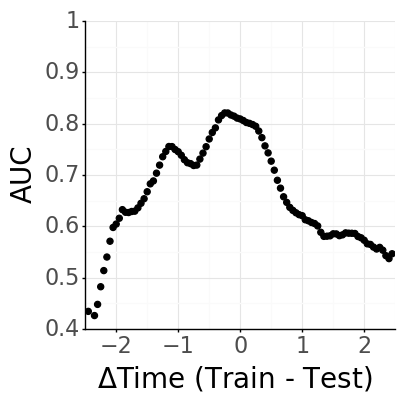

<ggplot: (435222703)>

In [21]:
df_temp = df_tempgen.copy()
df_temp['tdiff'] = df_temp['traintime'].values - df_temp['testtime'].values

df_temp['tdiff'] = df_temp.tdiff.round(decimals=2)
df_temp = df_temp.groupby(['tdiff'],as_index=False).mean()

p = (ggplot(df_temp,aes(x='tdiff',y='accs')) +
     geom_point(color='black',size=2)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_x_continuous(name='$\Delta$Time (Train - Test)') +
     scale_y_continuous(name='AUC') +
     coord_cartesian(xlim = (-2.5,2.5), ylim = (0.4,1),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save('figures/real_tempgen_diag_mfc.svg')
p.save('figures/real_tempgen_diag_mfc.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

In [111]:
df_temp = df_tempgen.copy()
df_temp['tdiff'] = df_temp['traintime'].values - df_temp['testtime'].values

df_temp['tdiff'] = df_temp.tdiff.round(decimals=2)
df_temp = df_temp[(df_temp.traintime >= -0.7) & (df_temp.testtime >= -0.7)]
df_temp = df_temp.groupby(['tdiff'],as_index=False).mean()
df_temp

,tdiff,accs,traintime,testtime
0,-0.65,0.800000,-0.699,-0.049
1,-0.60,0.805000,-0.674,-0.074
2,-0.55,0.800000,-0.649,-0.099
3,-0.50,0.830000,-0.624,-0.124
4,-0.45,0.838000,-0.599,-0.149
5,-0.40,0.858333,-0.574,-0.174
6,-0.35,0.865714,-0.549,-0.199
7,-0.30,0.868750,-0.524,-0.224
8,-0.25,0.880000,-0.499,-0.249
9,-0.20,0.890000,-0.474,-0.274


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/real_tempgen_diag_late.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/real_tempgen_diag_late.png


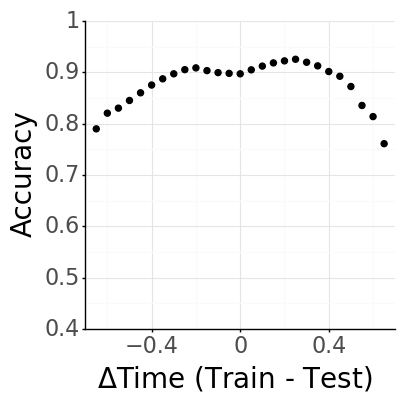

<ggplot: (445931786)>

In [76]:
df_temp = df_tempgen.copy()
df_temp['tdiff'] = df_temp['traintime'].values - df_temp['testtime'].values

df_temp['tdiff'] = df_temp.tdiff.round(decimals=2)
df_temp = df_temp[(df_temp.traintime >= -0.7) & (df_temp.testtime >= -0.7)]
df_temp = df_temp.groupby(['tdiff'],as_index=False).mean()

p = (ggplot(df_temp,aes(x='tdiff',y='accs')) +
     geom_point(color='black',size=2)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_x_continuous(name='$\Delta$Time (Train - Test)') +
     scale_y_continuous(name='Accuracy') +
     coord_cartesian(xlim = (-0.7,+0.7), ylim = (0.4,1),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save('figures/real_tempgen_diag_late.svg')
p.save('figures/real_tempgen_diag_late.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/real_tempgen_diag_all.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/real_tempgen_diag_all.png


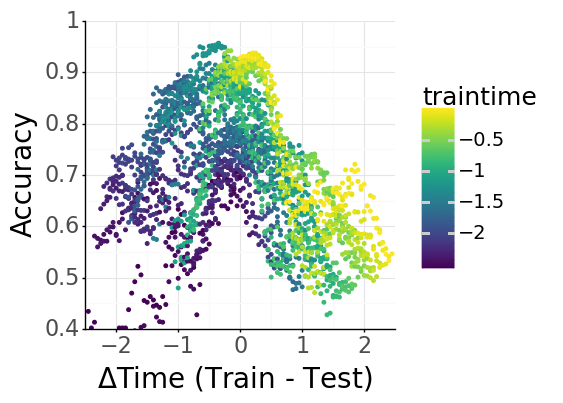

<ggplot: (435390943)>

In [22]:
df_temp = df_tempgen.copy()
df_temp['tdiff'] = df_temp['traintime'].values - df_temp['testtime'].values

df_temp['tdiff'] = df_temp.tdiff.round(decimals=2)
df_temp = df_temp.groupby(['tdiff','traintime'],as_index=False).mean()

p = (ggplot(df_temp,aes(x='tdiff',y='accs',color='traintime')) +
     geom_point(size=1)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_x_continuous(name='$\Delta$Time (Train - Test)') +
     scale_y_continuous(name='Accuracy') +
     coord_cartesian(xlim = (-2.5,2.5), ylim = (0.4,1),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save('figures/real_tempgen_diag_all.svg')
p.save('figures/real_tempgen_diag_all.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

## Synthetic Data

In [38]:
nettype = 'flux'
ksyn = 0.5
network = 5

fpath = './data/'+nettype+'/Ksyn_'+str(ksyn)+'/'

files = find_csv_filenames(fpath,suffix=".mat")

temp = loadmat(fpath+files[network-1])

spks = temp['spks']
time = temp['time'] / 1000


baseline_ix = np.where(np.logical_and(time > -3.0,time < -2.6))[1]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

df_base = pd.DataFrame(baseline_frs)
df_base['label'] = np.zeros(len(df_base,))

In [24]:
accs = []
sems = []

for tt in time[time > -2.5][::50]:
    
    this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[1]
    this_frs = spks[:,:,this_ix].sum(axis=2)
    
    df_this = pd.DataFrame(this_frs)
    df_this['label'] = np.ones(len(df_this,))
    
    tmp = pd.concat([df_base,df_this]).dropna()
    
    X = tmp.drop('label',axis=1).to_numpy()
    y = tmp['label'].to_numpy().flatten()
    
    
    kf = KFold(n_splits=len(y), random_state=0,shuffle=True)
    
    accs_this = []

    for train_ix, test_ix in kf.split(X):
        
        clf = LDA()
#         clf = SVC()
        
        clf.fit(X[train_ix],y[train_ix])
        
        accs_this.append(clf.score(X[test_ix],y[test_ix]))
#         accs_this.append(roc_auc_score(y[test_ix],clf.predict_proba(X[test_ix])[:,1]))

        
    accs.append(np.mean(accs_this))
    sems.append(sem(accs_this))
        
        
accs = np.array(accs)
sems = np.array(sems)
        
    

In [25]:
accs_shuffle = []
sems_shuffle = []

for tt in time[time > -2.5][::50]:
    
    this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[1]
    this_frs = spks[:,:,this_ix].sum(axis=2)
    
    df_this = pd.DataFrame(this_frs)
    df_this['label'] = np.ones(len(df_this,))
    
    tmp = pd.concat([df_base,df_this]).dropna()
    
    X = tmp.drop('label',axis=1).to_numpy()
    
    
    accs_this = []
    for ii in range(25):
        y = tmp['label'].to_numpy().flatten()
        random.shuffle(y)


        kf = KFold(n_splits=2, random_state=0,shuffle=True)

        

        for train_ix, test_ix in kf.split(X):

            clf = LDA()
#             clf = SVC()

            clf.fit(X[train_ix],y[train_ix])

            accs_this.append(clf.score(X[test_ix],y[test_ix]))
#             accs_this.append(roc_auc_score(y[test_ix],clf.predict_proba(X[test_ix])[:,1]))


    accs_shuffle.append(np.mean(accs_this))
#     sems_shuffle.append(sem(accs_this))
        
        
accs_shuffle = np.array(accs_shuffle)
# sems_shuffle = np.array(sems_shuffle)
        
    

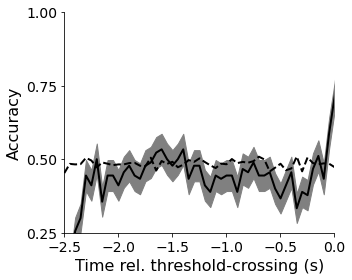

In [26]:
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

plt.plot(time[time > -2.5][::50],accs,'k',lw=2)
plt.fill_between(time[time > -2.5][::50],accs+sems,accs-sems,color='gray')


plt.plot(time[time > -2.5][::50],accs_shuffle,'k--',lw=2)
# plt.fill_between(time[time > -2.5][::25],accs+sems,accs-sems,color='gray')


plt.xlim((-2.5,0))
plt.ylim((0.3,1))

plt.xlabel('Time rel. threshold-crossing (s)',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(-2.5,0.1,0.5))
ax.set_yticks(np.arange(0.25,1.1,0.25))
ax.tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('figures/decoding/' + nettype + '_ksyn_' +str(ksyn) +'_net_'+str(network)+'_clf.svg')
plt.savefig('figures/decoding/' + nettype + '_ksyn_' +str(ksyn) +'_net_'+str(network)+'_clf.png')


plt.show()

# Temporal Generalization Analysis

In [174]:
nettype = 'flux'
ksyn = 0.5
network = 5

fpath = './data/'+nettype+'/Ksyn_'+str(ksyn)+'/'

files = find_csv_filenames(fpath,suffix=".mat")

temp = loadmat(fpath+files[network-1])

spks = temp['spks']
time = temp['time'] / 1000


baseline_ix = np.where(np.logical_and(time > -3,time < -2.6))[1]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

df_base = pd.DataFrame(baseline_frs)
df_base['label'] = np.zeros(len(df_base,))

accs = []
# sems = []
traintime = []
testtime = []

for tt_train in time[time > -2.5][::50]:
    for tt_test in time[time > -2.5][::50]:
        
    
#         if tt_train == tt_test:
#             this_ix = np.where(np.logical_and(time > tt_train-0.4,time < tt_train))[0]
#             this_frs = spks[:,:,this_ix].sum(axis=2)

#             df_this = pd.DataFrame(this_frs.T)
#             df_this['label'] = np.ones(len(df_this,))

#             tmp = pd.concat([df_base,df_this]).dropna()

#             X = tmp.drop('label',axis=1).to_numpy()
#             y = tmp['label'].to_numpy().flatten()


#             kf = KFold(n_splits=10, random_state=0,shuffle=True)

#             accs_this = []

#             for train_ix, test_ix in kf.split(X):

# #                 clf = LDA()
#                 clf = SVC()

#                 clf.fit(X[train_ix],y[train_ix])

#                 accs_this.append(clf.score(X[test_ix],y[test_ix]))
#         #         accs_this.append(roc_auc_score(y[test_ix],clf.predict_proba(X[test_ix])[:,1]))


        
#             accs.append(np.mean(accs_this))
# #             sems.append(sem(accs_this))
#             traintime.append(tt_train)
#             testtime.append(tt_test)
        
#             print(tt_train,np.mean(accs_this))
            
#         else:
        train_ix = np.where(np.logical_and(time > tt_train-0.4,time < tt_train))[1]
        train_frs = spks[:,:,train_ix].sum(axis=2)

        df_train = pd.DataFrame(train_frs)
        df_train['label'] = np.ones(len(df_train,))

        tmp = pd.concat([df_base,df_train]).dropna()
        X_train = tmp.drop('label',axis=1).to_numpy()
        y_train = tmp['label'].to_numpy().flatten()

        test_ix = np.where(np.logical_and(time > tt_test - 0.4,time < tt_test))[1]
        test_frs = spks[:,:,test_ix].sum(axis=2)

        df_test = pd.DataFrame(test_frs)
        df_test['label'] = np.ones(len(df_test,))

        tmp = pd.concat([df_base,df_test]).dropna()
        X_test = tmp.drop('label',axis=1).to_numpy()
        y_test = tmp['label'].to_numpy().flatten()

        clf = LDA()
#             clf = SVC()

        clf.fit(X_train,y_train)

#         accs_this = clf.score(X_test,y_test)
        accs_this = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

        

        accs.append(accs_this)
        traintime.append(tt_train)
        testtime.append(tt_test)
        
        if tt_train == tt_test:
            print(tt_train,accs_this)
        
        
        
df_tempgen = pd.DataFrame({'accs':accs,'traintime':traintime,'testtime':testtime})

-2.499857102029151 0.6635160680529301


KeyboardInterrupt: 

In [54]:
print("T-Test output: ",ttest_ind(df_tempgen.loc[df_tempgen.traintime.values > df_tempgen.testtime.values,'accs'],
               df_tempgen.loc[df_tempgen.traintime.values < df_tempgen.testtime.values,'accs']))
print("Rank-Sum output: ",ranksums(df_tempgen.loc[df_tempgen.traintime.values > df_tempgen.testtime.values,'accs'],
               df_tempgen.loc[df_tempgen.traintime.values < df_tempgen.testtime.values,'accs']))

T-Test output:  Ttest_indResult(statistic=-27.351233766408306, pvalue=1.387367227825145e-149)
Rank-Sum output:  RanksumsResult(statistic=-25.37561045560316, pvalue=4.688690631597574e-142)


In [175]:
spks.shape

(25, 320, 3500)

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/decoding/auc_flux_ksyn_0.5_net_5_2D.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/decoding/auc_flux_ksyn_0.5_net_5_2D.png


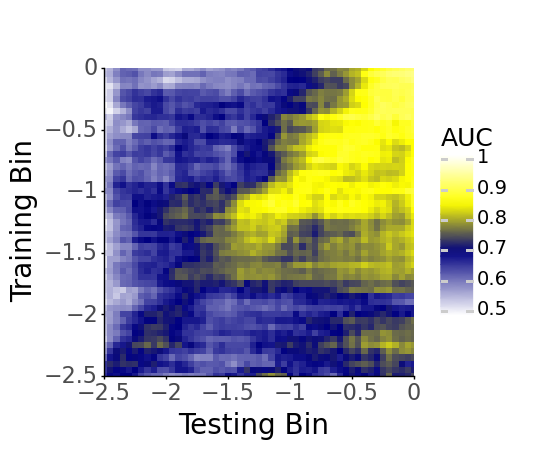

<ggplot: (434433290)>

In [55]:
p = (ggplot(df_tempgen,aes(x='testtime',y='traintime',fill='accs')) +
     geom_raster(interpolate=False)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
#      scale_fill_gradient2(name='AUC',
# # #                             high = '#a6212c', # More muted
# # #                           low = '#212ca6',
#                           high = 'yellow', # More vibrant
#                           low = 'navy',
#                           mid = 'teal',
#                           na_value='white',
#                           midpoint=0.6,
#                           limits=(0.3,1)) +
     scale_fill_gradientn(name='AUC',
                          colors = ['white','navy','yellow','white'],
                          values = [0.,0.4,0.7,1],
                          na_value='white',
                          limits=(0.5,1)) +
     scale_x_continuous(name='Testing Bin') +
     scale_y_continuous(name='Training Bin') +
     coord_cartesian(xlim = (-2.5,0), ylim = (-2.5,0),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save('figures/decoding/auc_' + nettype + '_ksyn_' +str(ksyn) +'_net_'+str(network)+'_2D.svg')
p.save('figures/decoding/auc_' + nettype + '_ksyn_' +str(ksyn) +'_net_'+str(network)+'_2D.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/decoding/auc_flux_ksyn_0.5_net_5_tempgen_avg.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/decoding/auc_flux_ksyn_0.5_net_5_tempgen_avg.png


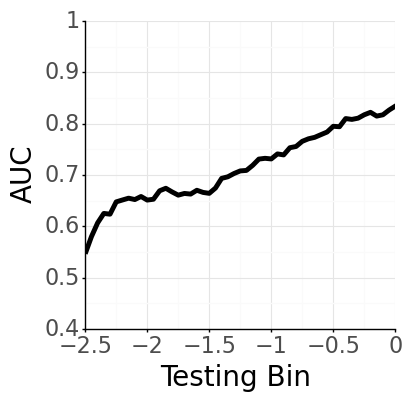

<ggplot: (435106856)>

In [56]:
df_temp = df_tempgen.groupby(['testtime'],as_index=False).mean()

p = (ggplot(df_temp,aes(x='testtime',y='accs')) +
     geom_line(color='black',size=2)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_x_continuous(name='Testing Bin') +
     scale_y_continuous(name='AUC') +
     coord_cartesian(xlim = (-2.5,0), ylim = (0.4,1),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save('figures/decoding/auc_' + nettype + '_ksyn_' +str(ksyn) +'_net_'+str(network)+'_tempgen_avg.svg')
p.save('figures/decoding/auc_' + nettype + '_ksyn_' +str(ksyn) +'_net_'+str(network)+'_tempgen_avg.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/decoding/auc_flux_ksyn_0.5_net_5_tempgen_diag.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/decoding/auc_flux_ksyn_0.5_net_5_tempgen_diag.png


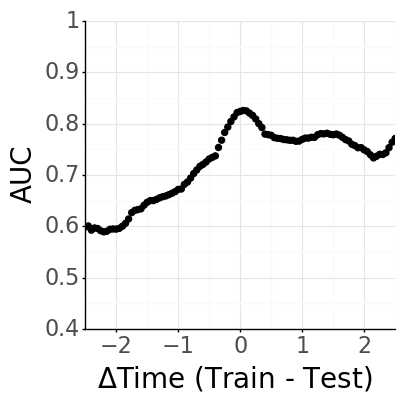

<ggplot: (435390913)>

In [57]:
df_temp = df_tempgen.copy()
df_temp['tdiff'] = df_temp['testtime'].values - df_temp['traintime'].values

df_temp['tdiff'] = df_temp.tdiff.round(decimals=2)
df_temp = df_temp.groupby(['tdiff'],as_index=False).mean()

p = (ggplot(df_temp,aes(x='tdiff',y='accs')) +
     geom_point(color='black',size=2)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_x_continuous(name='$\Delta$Time (Train - Test)') +
     scale_y_continuous(name='AUC') +
     coord_cartesian(xlim = (-2.5,2.5), ylim = (0.4,1),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save('figures/decoding/auc_' + nettype + '_ksyn_' +str(ksyn) +'_net_'+str(network)+'_tempgen_diag.svg')
p.save('figures/decoding/auc_' + nettype + '_ksyn_' +str(ksyn) +'_net_'+str(network)+'_tempgen_diag.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

## Decoding Accuracy for both slow & fast synapse networks

In [195]:
nettype = 'flux'
ksyn = 0.5
network = 17

fpath = './data/'+nettype+'/Ksyn_'+str(ksyn)+'/'

files = find_csv_filenames(fpath,suffix=".mat")

temp = loadmat(fpath+files[network-1])

spks = temp['spks']
time = temp['time'] / 1000


baseline_ix = np.where(np.logical_and(time > -3.0,time < -2.6))[1]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

df_base = pd.DataFrame(baseline_frs)
df_base['label'] = np.zeros(len(df_base,))

In [196]:
accs = []
sems = []

for tt in time[time > -2.5][::50]:
    
    this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[1]
    this_frs = spks[:,:,this_ix].sum(axis=2)
    
    df_this = pd.DataFrame(this_frs)
    df_this['label'] = np.ones(len(df_this,))
    
    tmp = pd.concat([df_base,df_this]).dropna()
    
    X = tmp.drop('label',axis=1).to_numpy()
    y = tmp['label'].to_numpy().flatten()

    
    kf = KFold(n_splits=5, random_state=0,shuffle=True)
    
    accs_this = []

    for train_ix, test_ix in kf.split(X):
        
        
        
        clf = LDA()
#         clf = SVC()
        
        clf.fit(X[train_ix],y[train_ix])
        
#         accs_this.append(clf.score(X[test_ix],y[test_ix]))
        accs_this.append(roc_auc_score(y[test_ix],clf.predict_proba(X[test_ix])[:,1]))

        
    accs.append(np.mean(accs_this))
    sems.append(sem(accs_this))
        
        
accs = np.array(accs)
sems = np.array(sems)
        
    

In [197]:
accs_shuffle = []
sems_shuffle = []

for tt in time[time > -2.5][::50]:
    
    this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[1]
    this_frs = spks[:,:,this_ix].sum(axis=2)
    
    df_this = pd.DataFrame(this_frs)
    df_this['label'] = np.ones(len(df_this,))
    
    tmp = pd.concat([df_base,df_this]).dropna()
    
    X = tmp.drop('label',axis=1).to_numpy()
    
    accs_this = []
    for ii in range(100):
        
        try:
            y = tmp['label'].to_numpy().flatten()
            random.shuffle(y)


            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=ii)


            clf = LDA()
    #         clf = SVC(probability = True)

            clf.fit(X_train,y_train)

    #         accs_this.append(clf.score(X_test,y_test))
            accs_this.append(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))
        except:
            print(f"Random state {ii} does not work for calculating AUC")


    accs_shuffle.append(np.mean(accs_this))
    sems_shuffle.append(sem(accs_this))
        
        
accs_shuffle = np.array(accs_shuffle)
sems_shuffle = np.array(sems_shuffle)
        
    

Random state 59 does not work for calculating AUC
Random state 35 does not work for calculating AUC
Random state 39 does not work for calculating AUC
Random state 51 does not work for calculating AUC
Random state 13 does not work for calculating AUC
Random state 57 does not work for calculating AUC
Random state 98 does not work for calculating AUC
Random state 30 does not work for calculating AUC
Random state 9 does not work for calculating AUC
Random state 38 does not work for calculating AUC
Random state 79 does not work for calculating AUC
Random state 20 does not work for calculating AUC
Random state 91 does not work for calculating AUC
Random state 29 does not work for calculating AUC
Random state 55 does not work for calculating AUC
Random state 25 does not work for calculating AUC
Random state 48 does not work for calculating AUC
Random state 7 does not work for calculating AUC
Random state 88 does not work for calculating AUC
Random state 84 does not work for calculating AUC
Ra

In [198]:
nettype = 'flux'
ksyn = 0

fpath = './data/'+nettype+'/Ksyn_'+str(ksyn)+'/'

files = find_csv_filenames(fpath,suffix=".mat")

temp = loadmat(fpath+files[network-1])

spks = temp['spks']
time = temp['time'] / 1000


baseline_ix = np.where(np.logical_and(time > -3.0,time < -2.6))[1]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

df_base = pd.DataFrame(baseline_frs)
df_base['label'] = np.zeros(len(df_base,))

In [199]:
accs_fast = []
sems_fast = []

for tt in time[time > -2.5][::50]:
    
    this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[1]
    this_frs = spks[:,:,this_ix].sum(axis=2)
    
    df_this = pd.DataFrame(this_frs)
    df_this['label'] = np.ones(len(df_this,))
    
    tmp = pd.concat([df_base,df_this]).dropna()
    
    X = tmp.drop('label',axis=1).to_numpy()
    y = tmp['label'].to_numpy().flatten()
    
    
    kf = KFold(n_splits=5, random_state=0,shuffle=True)
    
    accs_this = []

    for train_ix, test_ix in kf.split(X):
        
        clf = LDA()
#         clf = SVC()
        
        clf.fit(X[train_ix],y[train_ix])
        
#         accs_this.append(clf.score(X[test_ix],y[test_ix]))
        accs_this.append(roc_auc_score(y[test_ix],clf.predict_proba(X[test_ix])[:,1]))

        
    accs_fast.append(np.mean(accs_this))
    sems_fast.append(sem(accs_this))
        
        
accs_fast = np.array(accs_fast)
sems_fast = np.array(sems_fast)
        
    

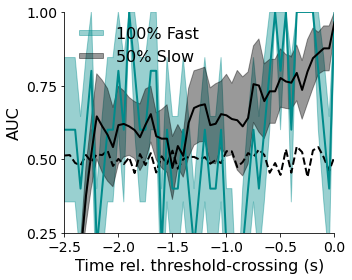

In [200]:
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

plt.plot(time[time > -2.5][::50],accs_shuffle,'k--',lw=2)
# plt.fill_between(time[time > -2.5][::25],accs+sems,accs-sems,color='gray')

plt.plot(time[time > -2.5][::50],accs_fast,'darkcyan',lw=2)
plt.fill_between(time[time > -2.5][::50],accs_fast+sems_fast,accs_fast-sems_fast,color='darkcyan',label='100% Fast',alpha=0.4)

plt.plot(time[time > -2.5][::50],accs,'k',lw=2)
plt.fill_between(time[time > -2.5][::50],accs+sems,accs-sems,color='black',label='50% Slow',alpha=0.4)





plt.xlim((-2.5,0))
plt.ylim((0.3,1))

plt.xlabel('Time rel. threshold-crossing (s)',fontsize=16)
plt.ylabel('AUC',fontsize=16)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(-2.5,0.1,0.5))
ax.set_yticks(np.arange(0.25,1.1,0.25))
ax.tick_params(labelsize=14)

lgnd = ax.legend(loc=2, prop={'size': 16},frameon=False,handlelength=1.5,handleheight=0.1)

#change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_lw(6)
# lgnd.legendHandles[1]._legmarker.set_lw(6)


plt.tight_layout()

plt.savefig('figures/decoding/auc_' + nettype + '_net_'+str(network)+'_clf.svg')
plt.savefig('figures/decoding/auc_' + nettype + '_net_'+str(network)+'_clf.png')


plt.show()



In [181]:
time_decim = time[time > -2.5][::50]

auc75 = []

time_decim[np.where(accs_fast > 0.75)[0][0]]

0.0008573878250927009

In [182]:
np.where(accs_fast > 0.75)[0][0]

time_decim

array([-2.49985710e+00, -2.44984281e+00, -2.39982852e+00, -2.34981423e+00,
       -2.29979994e+00, -2.24978565e+00, -2.19977136e+00, -2.14975707e+00,
       -2.09974278e+00, -2.04972849e+00, -1.99971420e+00, -1.94969991e+00,
       -1.89968562e+00, -1.84967133e+00, -1.79965704e+00, -1.74964276e+00,
       -1.69962847e+00, -1.64961418e+00, -1.59959989e+00, -1.54958560e+00,
       -1.49957131e+00, -1.44955702e+00, -1.39954273e+00, -1.34952844e+00,
       -1.29951415e+00, -1.24949986e+00, -1.19948557e+00, -1.14947128e+00,
       -1.09945699e+00, -1.04944270e+00, -9.99428408e-01, -9.49414118e-01,
       -8.99399829e-01, -8.49385539e-01, -7.99371249e-01, -7.49356959e-01,
       -6.99342669e-01, -6.49328380e-01, -5.99314090e-01, -5.49299800e-01,
       -4.99285510e-01, -4.49271220e-01, -3.99256931e-01, -3.49242641e-01,
       -2.99228351e-01, -2.49214061e-01, -1.99199771e-01, -1.49185482e-01,
       -9.91711918e-02, -4.91569020e-02,  8.57387825e-04,  5.08716776e-02,
        1.00885967e-01,  

## Quantifying the times at which the decoding AUC reach 75%

In [216]:
time_decim = time[time > -2.5][::50]

auc75_slow = []
auc75_fast = []


for ii in range(20):

    nettype = 'flux'
    ksyn = 0.5
    network = ii
    
    print(f"Classifying network {network+1}")

    fpath = './data/'+nettype+'/Ksyn_'+str(ksyn)+'/'

    files = find_csv_filenames(fpath,suffix=".mat")

    temp = loadmat(fpath+files[network-1])

    spks = temp['spks']
    time = temp['time'] / 1000
    
    accs_fast = []
    sems_fast = []

    accs = []
    sems = []


    baseline_ix = np.where(np.logical_and(time > -3.0,time < -2.6))[1]
    baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

    df_base = pd.DataFrame(baseline_frs)
    df_base['label'] = np.zeros(len(df_base,))

    for tt in time[time > -2.5][::50]:

        this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[1]
        this_frs = spks[:,:,this_ix].sum(axis=2)

        df_this = pd.DataFrame(this_frs)
        df_this['label'] = np.ones(len(df_this,))

        tmp = pd.concat([df_base,df_this]).dropna()

        X = tmp.drop('label',axis=1).to_numpy()
        y = tmp['label'].to_numpy().flatten()


        kf = KFold(n_splits=5, random_state=0,shuffle=True)

        accs_this = []

        for train_ix, test_ix in kf.split(X):



            clf = LDA()
    #         clf = SVC()

            clf.fit(X[train_ix],y[train_ix])

    #         accs_this.append(clf.score(X[test_ix],y[test_ix]))
            accs_this.append(roc_auc_score(y[test_ix],clf.predict_proba(X[test_ix])[:,1]))


        accs.append(np.mean(accs_this))
        sems.append(sem(accs_this))


    accs = np.array(accs)
    sems = np.array(sems)


    nettype = 'flux'
    ksyn = 0

    fpath = './data/'+nettype+'/Ksyn_'+str(ksyn)+'/'

    files = find_csv_filenames(fpath,suffix=".mat")

    temp = loadmat(fpath+files[network-1])

    spks = temp['spks']
    time = temp['time'] / 1000


    baseline_ix = np.where(np.logical_and(time > -3.0,time < -2.6))[1]
    baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

    df_base = pd.DataFrame(baseline_frs)
    df_base['label'] = np.zeros(len(df_base,))

    for tt in time[time > -2.5][::50]:

        this_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[1]
        this_frs = spks[:,:,this_ix].sum(axis=2)

        df_this = pd.DataFrame(this_frs)
        df_this['label'] = np.ones(len(df_this,))

        tmp = pd.concat([df_base,df_this]).dropna()

        X = tmp.drop('label',axis=1).to_numpy()
        y = tmp['label'].to_numpy().flatten()


        kf = KFold(n_splits=5, random_state=0,shuffle=True)

        accs_this = []

        for train_ix, test_ix in kf.split(X):

            clf = LDA()
    #         clf = SVC()

            clf.fit(X[train_ix],y[train_ix])

    #         accs_this.append(clf.score(X[test_ix],y[test_ix]))
            accs_this.append(roc_auc_score(y[test_ix],clf.predict_proba(X[test_ix])[:,1]))


        accs_fast.append(np.mean(accs_this))
        sems_fast.append(sem(accs_this))


    accs_fast = np.array(accs_fast)
    sems_fast = np.array(sems_fast)


    # Restrict so that we only consider times after -1.75 seconds because fast synapse net 17 is super chaotic
    # Based on testing this doesn't affect any other networks or any of the slow networks
    auc75_slow.append(time_decim[np.where((accs > 0.75) & (time_decim > -1.55))[0][0]])
    auc75_fast.append(time_decim[np.where((accs_fast > 0.75) & (time_decim > -1.55))[0][0]])
    
auc75_slow = np.array(auc75_slow)
auc75_fast = np.array(auc75_fast)

Classifying network 1
Classifying network 2
Classifying network 3
Classifying network 4
Classifying network 5
Classifying network 6
Classifying network 7
Classifying network 8
Classifying network 9
Classifying network 10
Classifying network 11
Classifying network 12
Classifying network 13
Classifying network 14
Classifying network 15
Classifying network 16
Classifying network 17
Classifying network 18
Classifying network 19
Classifying network 20


In [217]:
auc75_slow = np.array(auc75_slow)
auc75_fast = np.array(auc75_fast)
# print(f"Mean time of AUC > 0.75 for slow nets: {np.mean(auc75_slow[np.arange(len(auc75_slow))!=17])}, standard error: {sem(auc75_slow[np.arange(len(auc75_slow))!=17])}")
# print(f"Mean time of AUC > 0.75 for fast nets: {np.mean(auc75_fast[np.arange(len(auc75_fast))!=17])}, standard error: {sem(auc75_fast[np.arange(len(auc75_fast))!=17])}")

print(f"Mean time of AUC > 0.75 for slow nets: {np.mean(auc75_slow)}, standard error: {sem(auc75_slow)}")
print(f"Mean time of AUC > 0.75 for fast nets: {np.mean(auc75_fast)}, standard error: {sem(auc75_fast)}")

Mean time of AUC > 0.75 for slow nets: -0.6418262360674479, standard error: 0.07131249089722143
Mean time of AUC > 0.75 for fast nets: -0.031651900543012444, standard error: 0.02998114122430578


In [202]:
auc75_slow[np.arange(len(auc75_slow))!=17]

TypeError: only integer scalar arrays can be converted to a scalar index

In [218]:
auc75_fast

array([ 0.00085739,  0.00085739,  0.00085739,  0.00085739,  0.00085739,
        0.00085739,  0.00085739,  0.00085739, -0.0491569 ,  0.00085739,
        0.00085739,  0.00085739,  0.00085739,  0.00085739,  0.00085739,
        0.00085739,  0.00085739, -0.59931409,  0.00085739,  0.00085739])

In [205]:
np.where(accs_fast > 0.75)

(array([ 5, 10, 12, 13, 16, 17, 38, 39, 40, 41, 43, 44, 45, 46, 47, 50, 51,
        52, 53, 54, 55, 56, 57, 58]),)

In [212]:
np.where((accs > 0.75) & (time_decim > -1.75))

(array([36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59]),)

In [211]:
accs.shape

(60,)

# Euclidean Distance Analysis

In [158]:
nettype = 'flux'
ksyn = 0.5
network = 5

fpath = './data/'+nettype+'/Ksyn_'+str(ksyn)+'/'

files = find_csv_filenames(fpath,suffix=".mat")

temp = loadmat(fpath+files[network-1])

spks = temp['spks']
time = temp['time'] / 1000

In [159]:
def vec_dist(a,b):
    return ((a-b) @ (a-b))**(1/2)

In [160]:
frames = []

baseline_ix = np.where(np.logical_and(time > -3,time < -2.6))[1]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

for tt in time[time > -2.5][::50]:
    distances = []
    
    train_ix = np.where(np.logical_and(time > tt-0.4,time < tt))[1]
    train_frs = spks[:,:,train_ix].sum(axis=2)
    
    for trialnum in range(spks.shape[0]):
        
        distances.append(vec_dist(baseline_frs[trialnum,:],train_frs[trialnum,:]))
    
    df_t = pd.DataFrame({
        'distance':distances
    })
    df_t['time'] = tt
    
    frames.append(df_t)
    
df_dist = pd.concat(frames)
        
        

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 10 rows containing missing values.


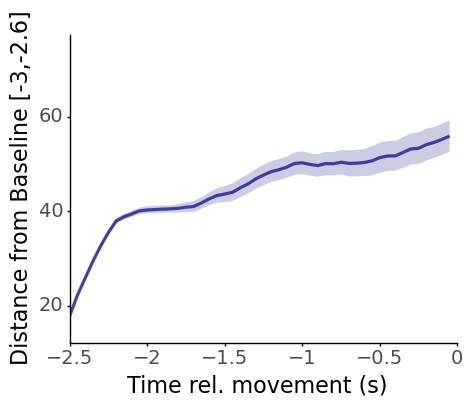

<ggplot: (435381685)>

In [161]:
df_temp = df_dist.groupby(['time'],as_index=False).mean()

df_temp['stderr'] = df_dist.groupby(['time'],as_index=False).sem()['distance']

df_temp['ci_high'] = df_temp.distance + df_temp.stderr
df_temp['ci_low'] = df_temp.distance - df_temp.stderr

p=(ggplot(df_temp,aes(x='time',y='distance', ymin = 'ci_low',ymax = 'ci_high')) +
geom_line(alpha=0.7,size=1.3,color='navy') + 
   geom_ribbon(alpha=0.2,color='none',show_legend=False,fill='navy') +
   scale_x_continuous(name='Time rel. movement (s)',breaks=np.arange(-3,1,0.5),limits=(-2.5,0.),expand = (0,0)) +
   scale_y_continuous(name='Distance from Baseline [-3,-2.6]',expand = (0.1,0.1)) +
   
 theme_classic() +
   theme(axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
        figure_size = (5,4))
)


# p.save(figurepath+'pupil/means_CI.svg')
# p.save(figurepath+'pupil/means_CI.png')
p

In [192]:
np.where(np.isnan(spks))

(array([16, 16, 16, ..., 22, 22, 22]),
 array([  0,   0,   0, ..., 319, 319, 319]),
 array([   0,    1,    2, ..., 3497, 3498, 3499]))

In [193]:
spks_temp = spks[~np.isnan(spks[:,0,0]),:,:]
spks_temp.shape

(23, 320, 3500)

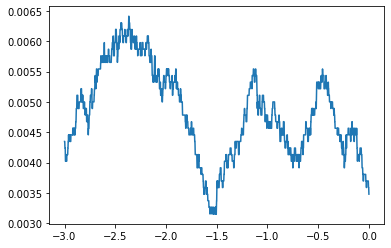

In [194]:
spks_mean = uniform_filter1d(spks_temp[:,:,0:-500],400)

spks_mean = np.mean(spks_mean,axis=0)

plt.plot(time[:,0:-500].T,spks_mean[1,:])

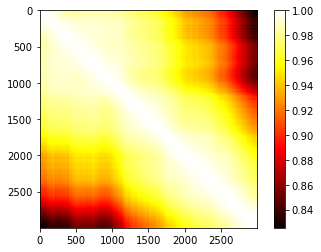

In [195]:
spks_cov = np.corrcoef(spks_mean.T)
plt.imshow(spks_cov, cmap='hot', interpolation='nearest')

plt.colorbar()

plt.show()